In [ ]:
# Imports
import os

import matplotlib.pyplot as plt  #  type: ignore
import numpy as np  #  type: ignore
import pandas as pd  #  type: ignore
from sklearn.datasets import make_regression  #  type: ignore
from sklearn.linear_model import LinearRegression  #  type: ignore
from sklearn.neighbors import KernelDensity  #  type: ignore
from tqdm import tqdm  #  type: ignore

In [ ]:
# Parte 1: Generación de la simulación para análisis
#
def run_simulation(n_runs):

    #
    # Directorio de resultados
    def create_results_folder():

        if not os.path.exists("../files/results"):
            os.makedirs("../files/results")

    #
    # Data generation
    def generate_data():

        X, y = make_regression(
            n_samples=100,
            n_features=3,
            noise=0.1,
            random_state=42,
        )
        df = pd.DataFrame(X, columns=["x1", "x2", "x3"])
        df["dummy1"] = np.random.normal(0, 1, 100)
        df["dummy2"] = np.random.normal(0, 1, 100)
        df["y"] = y

        return df

    #
    # Parameters estimation
    def get_model_params(df):

        X = df[["x1", "x2", "x3", "dummy1", "dummy2"]]
        y = df["y"]
        model = LinearRegression().fit(X, y)
        model = model.fit(X, y)
        return {
            "x1": model.coef_[0],
            "x2": model.coef_[1],
            "x3": model.coef_[2],
            "dummy1": model.coef_[3],
            "dummy2": model.coef_[4],
            "intercept": model.intercept_,
        }

    def run_experiment(df, variable, n_runs):
        #
        # El primer experimento contiene los parametros del modelo
        # sin permutar
        results = []
        params = get_model_params(df)
        result = {"variable": variable, "run": 0, "value": params[variable]}
        results.append(result)

        for i_run in tqdm(range(1, n_runs)):
            #
            # Permuta la columna de interes y estima nuevamente
            # los parametros del modelo
            permuted_df = df.copy()
            permuted_df[variable] = np.random.permutation(permuted_df[variable].values)
            params = get_model_params(permuted_df)
            result = {"variable": variable, "run": i_run, "value": params[variable]}
            results.append(result)

        return pd.DataFrame(results)

    def run_experiments(df, n_runs):
        df = generate_data()
        variables = ["x1", "x2", "x3", "dummy1", "dummy2"]
        results = pd.concat(
            [run_experiment(df, variable, n_runs) for variable in variables]
        )
        return results

    #
    # Simulation
    create_results_folder()
    df = generate_data()
    experiments = run_experiments(df, n_runs)
    experiments["run"] = experiments["run"].astype(int)
    experiments.to_csv("../files/results/experiments.csv", index=False)


#
# Ejecuta la simulacion
run_simulation(n_runs=1000)

100%|██████████| 999/999 [00:03<00:00, 300.20it/s]


In [ ]:
#
# Generación de estadísticas por cada variable
#
def compute_stats():

    experiments = pd.read_csv("../files/results/experiments.csv")

    #
    # Extrae el coeficiente estimado para cada variable con el dataset
    # original
    current_values = experiments.loc[experiments["run"] == 0].copy()
    current_values = current_values.drop(columns=["run"])
    current_values = current_values.rename(columns={"value": "original"})
    current_values = current_values.set_index("variable")

    #
    # Calcula los estadísticos descriptivos para cada variable
    stats = experiments[["variable", "value"]].groupby(["variable"]).describe()
    stats.columns = stats.columns.droplevel(0)

    #
    # Agrega el valor original
    stats = stats.join(current_values, on="variable")

    #
    # Genera el reporte
    with open("../files/results/stats.txt", "w") as file:
        file.write(stats.to_string())
    stats.to_csv("../files/results/stats.csv")


compute_stats()

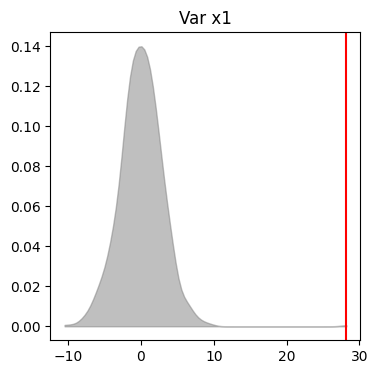

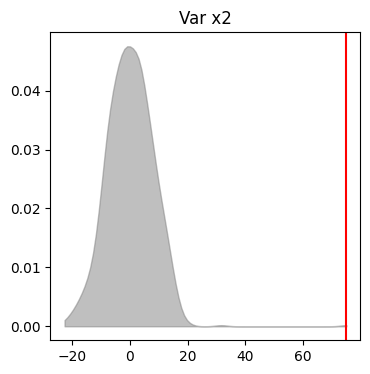

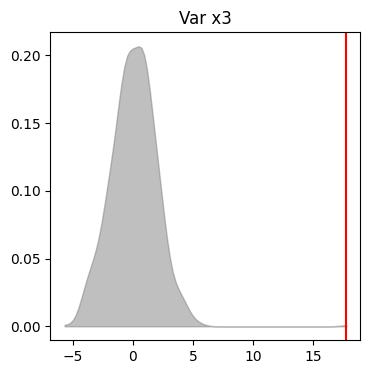

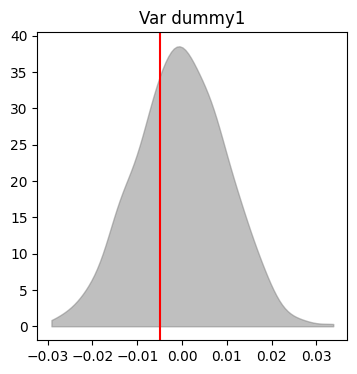

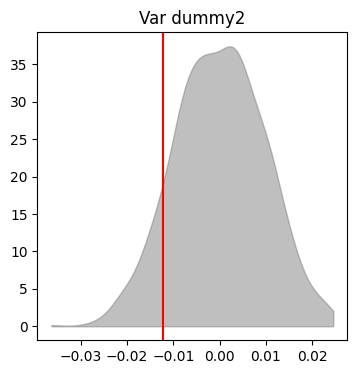

In [ ]:
#
# Generación de gráficos de análisis
#
def make_plots():

    experiments = pd.read_csv("../files/results/experiments.csv")

    for variable in experiments["variable"].drop_duplicates():

        plt.figure(figsize=(4, 4))

        sample = experiments[experiments["variable"] == variable].value
        x_min, x_max = sample.min(), sample.max()

        bandwidth = 1.06 * sample.std() * sample.size ** (-1 / 5)

        current_value = sample.iloc[0]
        kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(
            sample.values.reshape(-1, 1)
        )

        bins = np.linspace(x_min, x_max, 100)
        log_dens = kde.score_samples(bins.reshape(-1, 1))

        plt.fill_between(bins, np.exp(log_dens), alpha=0.5, color="gray")
        plt.axvline(current_value, color="red", linestyle="-")
        plt.title(f"Var {variable}")

        plt.show()


make_plots()